In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
from sklearn.model_selection import train_test_split
from scipy.io import savemat, loadmat
import pylab as plt
import numpy as np
from scipy.spatial.distance import cdist
from IPython.display import clear_output
import ipywidgets as ipw
import scipy.ndimage as ndimage
from scipy.interpolate import RegularGridInterpolator
import timeit
import pandas as pd
from tqdm import tqdm_notebook
from keras.layers import *

Using TensorFlow backend.


In [6]:
import sys
sys.path.append('../../')
import src.approximation as appr
import src.plot_utils as plot_utils
import src.ml_utils as ml_utils

from keras import optimizers
import keras

In [7]:
def data_input_layered():
    data = loadmat('../../data/layered_traveltimes.mat')
    vp = loadmat('../../data/layered_model.mat')['vp'].T
    time = data['time']
    sou = np.stack([np.float32(data['SX']), np.float32(data['SZ'])], axis=-1)
    rec = np.stack([np.float32(data['SX'][:,0]), np.float32(data['SX'][0,:])]).T
    return sou, rec, time, vp

def data_input_seg():
    data = loadmat('../../data/seg_traveltimes.mat')
    vp = loadmat('../../data/seg_model.mat')['Vp'].T
    time = data['time']
    sou = np.stack([np.float32(data['SX']), np.float32(data['SZ'])], axis=-1)
    rec = np.stack([np.float32(data['SX'][:,0]), np.float32(data['SX'][0,:])]).T
    return sou, rec, time, vp

def init_interpolation(sou, rec, time):
    x = rec[:,0]
    y = sou[0,:,1]
    z = sou[:,0,0]
    assert len(time.shape)>2 and time.shape[0]==rec.shape[0]
    
    return RegularGridInterpolator((x, y, z), time, method='linear', 
                                    bounds_error=False, fill_value=None)

## Import of data sets

In [8]:
sou, rec, time, vp = data_input_layered()

sou_x = sou[:,0,0]
sou_z = sou[0,:,1]
rec_x = rec[:, 0]
output = time[..., None]

scaler_x = ml_utils.Scaler(sou_x)
scaler_z = ml_utils.Scaler(sou_z)
sou_x_sc = scaler_x.scale(sou_x, verbose=True)
sou_z_sc = scaler_z.scale(sou_z)
rec_x_sc = scaler_x.scale(rec_x)

Before scaling:
Mean: 1000.0	Std: 580.22998046875
After scaling:
Mean: 0.0	Std: 1.0


In [9]:
train_set = appr.Approximator.prepare_inputs(inputs=[rec_x_sc, sou_x_sc, sou_z_sc], outputs=output, 
                                                        flatenned=False, sparse=[1,10,10])
test_set = appr.Approximator.prepare_inputs(inputs=[rec_x_sc, sou_x_sc, sou_z_sc], outputs=output, 
                                                        flatenned=False, sparse=[1,1,1])

## Testing number of layers and units

In [33]:
model = appr.Approximator(1, num_units=[3000], input_dim=1, 
                          output_dim=1, num_inputs=3)
model.description

{'num_layers': 1,
 'num_units': [3000],
 'activations': ['relu'],
 'initializations': ['random_normal'],
 'biases': [True],
 'input_dim': 1,
 'output_dim': 1,
 'num_inputs': 3,
 'input_names': ['input_0', 'input_1', 'input_2']}

In [30]:
adam = optimizers.Adam(lr=1e-3, decay=1e-4, amsgrad=False)
plot_losses = ml_utils.PlotLosses()
early = keras.callbacks.EarlyStopping(monitor='mae', min_delta=1e-8, patience=4, verbose=2, 
                                        mode='auto', baseline=None, restore_best_weights=False)
reducer = keras.callbacks.ReduceLROnPlateau(monitor='mae', factor=0.75, patience=3, verbose=1, 
                                            mode='auto', min_delta=1e-7, cooldown=0, min_lr=1e-7)

callbacks = [
#             early,
            reducer,
#             plot_losses
            ]

In [34]:
model.nn_model.compile(optimizer=adam, loss='mse', metrics=['mae'])

In [35]:
model.nn_model.fit(x=train_set[0], y=train_set[1], 
                   batch_size=128, 
                   epochs=101, 
                   shuffle=True,
                   verbose=2,
                   callbacks=callbacks)

Epoch 1/101
 - 4s - loss: 0.0100 - mae: 0.0375
Epoch 2/101
 - 4s - loss: 2.4374e-04 - mae: 0.0102
Epoch 3/101
 - 4s - loss: 1.5278e-04 - mae: 0.0080
Epoch 4/101
 - 4s - loss: 1.2805e-04 - mae: 0.0074
Epoch 5/101
 - 4s - loss: 1.1845e-04 - mae: 0.0074
Epoch 6/101
 - 4s - loss: 1.0430e-04 - mae: 0.0071
Epoch 7/101
 - 4s - loss: 9.6180e-05 - mae: 0.0069
Epoch 8/101
 - 4s - loss: 9.7827e-05 - mae: 0.0070
Epoch 9/101
 - 4s - loss: 8.0988e-05 - mae: 0.0065
Epoch 10/101
 - 4s - loss: 7.0075e-05 - mae: 0.0061
Epoch 11/101
 - 4s - loss: 6.8341e-05 - mae: 0.0060
Epoch 12/101
 - 5s - loss: 5.9206e-05 - mae: 0.0056
Epoch 13/101
 - 5s - loss: 5.4742e-05 - mae: 0.0054
Epoch 14/101
 - 5s - loss: 4.6325e-05 - mae: 0.0050
Epoch 15/101
 - 4s - loss: 4.1193e-05 - mae: 0.0047
Epoch 16/101
 - 4s - loss: 4.3327e-05 - mae: 0.0048
Epoch 17/101
 - 4s - loss: 3.8606e-05 - mae: 0.0046
Epoch 18/101
 - 4s - loss: 3.6088e-05 - mae: 0.0044
Epoch 19/101
 - 4s - loss: 3.5540e-05 - mae: 0.0044
Epoch 20/101
 - 4s - loss

In [64]:
W = sou[:,::-1, 1]
factor = 0.1
W = (W - W.min()) / W.max() * factor + 1.0
W = W[::10, ::10]
W = np.repeat(W[None, ...], len(rec_x_sc), axis=0)

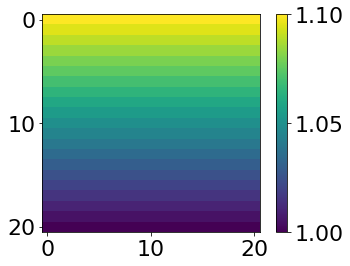

In [65]:
plt.imshow(W[0].T)
plt.colorbar()

In [66]:
model2 = appr.Approximator(1, num_units=[3000], input_dim=1, 
                          output_dim=1, num_inputs=3)
model2.description

{'num_layers': 1,
 'num_units': [3000],
 'activations': ['relu'],
 'initializations': ['random_normal'],
 'biases': [True],
 'input_dim': 1,
 'output_dim': 1,
 'num_inputs': 3,
 'input_names': ['input_0', 'input_1', 'input_2']}

In [67]:
model2.nn_model.compile(optimizer=adam, loss='mse', metrics=['mae'])

In [68]:
%%time
model2.nn_model.fit(x=train_set[0], y=train_set[1], 
                   batch_size=128, 
                   epochs=101, 
                   shuffle=True, 
                   verbose=2,
                   callbacks=callbacks, 
                   sample_weight=W.ravel())

Epoch 1/101
 - 4s - loss: 0.1271 - mae: 0.2510
Epoch 2/101
 - 4s - loss: 0.0245 - mae: 0.1133
Epoch 3/101
 - 4s - loss: 0.0165 - mae: 0.0911
Epoch 4/101
 - 4s - loss: 0.0115 - mae: 0.0730
Epoch 5/101
 - 4s - loss: 0.0081 - mae: 0.0585
Epoch 6/101
 - 4s - loss: 0.0060 - mae: 0.0478
Epoch 7/101
 - 4s - loss: 0.0046 - mae: 0.0408
Epoch 8/101
 - 4s - loss: 0.0036 - mae: 0.0362
Epoch 9/101
 - 4s - loss: 0.0029 - mae: 0.0327
Epoch 10/101
 - 4s - loss: 0.0023 - mae: 0.0298
Epoch 11/101
 - 4s - loss: 0.0019 - mae: 0.0272
Epoch 12/101
 - 4s - loss: 0.0016 - mae: 0.0249
Epoch 13/101
 - 4s - loss: 0.0013 - mae: 0.0229
Epoch 14/101
 - 4s - loss: 0.0012 - mae: 0.0212
Epoch 15/101
 - 4s - loss: 9.9503e-04 - mae: 0.0196
Epoch 16/101
 - 4s - loss: 8.6514e-04 - mae: 0.0182
Epoch 17/101
 - 4s - loss: 7.5674e-04 - mae: 0.0170
Epoch 18/101
 - 4s - loss: 6.6563e-04 - mae: 0.0158
Epoch 19/101
 - 4s - loss: 5.8869e-04 - mae: 0.0148
Epoch 20/101
 - 4s - loss: 5.2412e-04 - mae: 0.0139
Epoch 21/101
 - 4s - loss

In [69]:
%%time
t1 = model.nn_model.predict(test_set[0], 
                            batch_size=500000)
t2 = model2.nn_model.predict(test_set[0],
                            batch_size=500000)

Wall time: 2min 6s


In [70]:
mae1 = (t1 - test_set[1]).reshape((201,)*3)
mae2 = (t2 - test_set[1]).reshape((201,)*3)

In [55]:
from matplotlib import cm
from matplotlib.colors import Normalize

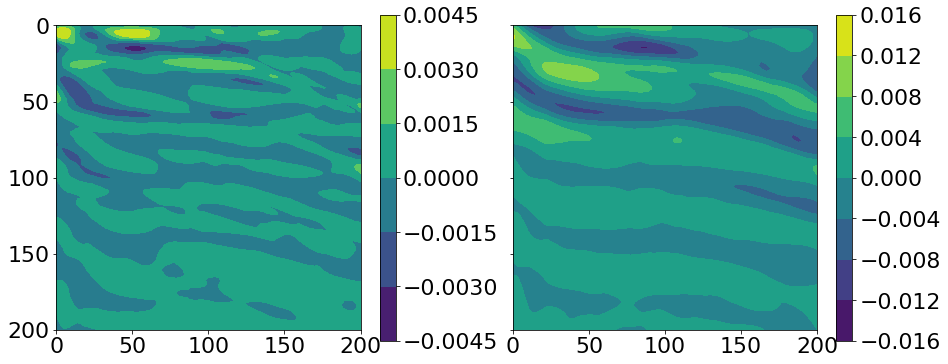

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharey='row')

# cmap = cm.viridis
# vmin = min(mae1.min(), mae2.min())
# vmax = max(mae1.max(), mae2.max())
# norm = Normalize(vmin, vmax, clip=True)

im1 = axes[0].contourf(mae1.mean(axis=0).T, extent=(0, 200, 0, 200))
axes[0].axis('scaled')
axes[0].set_ylim([200, 0])
plt.colorbar(mappable=im1, ax=axes[0])

im2 = axes[1].contourf(mae2.mean(axis=0).T, extent=(0, 200, 0, 200))
axes[1].axis('scaled')
axes[1].set_ylim([200, 0])
plt.colorbar(mappable=im2, ax=axes[1])

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(im1, cax=cbar_ax)

plt.show()

# Transferring trained model on Marmousi to another one

In [10]:
model = keras.models.load_model('../../nn_models/approximation/marmousi_trained10')

In [12]:
early = keras.callbacks.EarlyStopping(monitor='mae', min_delta=1e-8, patience=4, verbose=2, 
                                      mode='auto', baseline=None, restore_best_weights=False)

reducer = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.75, patience=3, verbose=1, 
                                            mode='auto', min_delta=1e-9, cooldown=1, min_lr=1e-7)
callbacks = [reducer, early]

In [23]:
adam = optimizers.Adam(lr=1e-3, decay=1e-4)
model2 = appr.Approximator(2, num_units=[500, 500], input_dim=1, 
                          output_dim=1, num_inputs=3)
model2.nn_model.compile(optimizer=adam, loss='mse', metrics=['mae'])
model2.description

{'num_layers': 2,
 'num_units': [500, 500],
 'activations': ['relu', 'relu'],
 'initializations': ['random_normal', 'random_normal'],
 'biases': [True, True],
 'input_dim': 1,
 'output_dim': 1,
 'num_inputs': 3,
 'input_names': ['input_0', 'input_1', 'input_2']}

In [13]:
history = model.fit(x=train_set[0], y=train_set[1], 
                    batch_size=128, 
                    epochs=102, 
                    verbose=2, 
                    callbacks=callbacks)

Epoch 1/102
88641/88641 [==============================] - ETA: 5:50 - loss: 3.5702 - mae: 1.610 - ETA: 1:18 - loss: 1.8856 - mae: 1.092 - ETA: 47s - loss: 1.1716 - mae: 0.803 - ETA: 35s - loss: 0.9907 - mae: 0.78 - ETA: 29s - loss: 0.8561 - mae: 0.74 - ETA: 25s - loss: 0.7135 - mae: 0.65 - ETA: 22s - loss: 0.6089 - mae: 0.57 - ETA: 20s - loss: 0.5386 - mae: 0.53 - ETA: 19s - loss: 0.4954 - mae: 0.50 - ETA: 19s - loss: 0.4567 - mae: 0.48 - ETA: 18s - loss: 0.4121 - mae: 0.44 - ETA: 17s - loss: 0.3761 - mae: 0.41 - ETA: 16s - loss: 0.3396 - mae: 0.38 - ETA: 15s - loss: 0.3092 - mae: 0.35 - ETA: 14s - loss: 0.2885 - mae: 0.33 - ETA: 14s - loss: 0.2705 - mae: 0.32 - ETA: 13s - loss: 0.2548 - mae: 0.30 - ETA: 13s - loss: 0.2408 - mae: 0.29 - ETA: 12s - loss: 0.2252 - mae: 0.28 - ETA: 12s - loss: 0.2141 - mae: 0.27 - ETA: 12s - loss: 0.2017 - mae: 0.25 - ETA: 11s - loss: 0.1907 - mae: 0.24 - ETA: 11s - loss: 0.1808 - mae: 0.23 - ETA: 10s - loss: 0.1720 - mae: 0.22 - ETA: 10s - loss: 0.1639 

88641/88641 [==============================] - ETA: 6s - loss: 5.1347e-04 - mae: 0.016 - ETA: 5s - loss: 4.7056e-04 - mae: 0.016 - ETA: 5s - loss: 4.6773e-04 - mae: 0.016 - ETA: 5s - loss: 4.4510e-04 - mae: 0.016 - ETA: 5s - loss: 4.2690e-04 - mae: 0.015 - ETA: 5s - loss: 4.2359e-04 - mae: 0.015 - ETA: 5s - loss: 4.1881e-04 - mae: 0.015 - ETA: 5s - loss: 4.2092e-04 - mae: 0.015 - ETA: 5s - loss: 4.1958e-04 - mae: 0.015 - ETA: 5s - loss: 4.1651e-04 - mae: 0.015 - ETA: 4s - loss: 4.1589e-04 - mae: 0.015 - ETA: 4s - loss: 4.1435e-04 - mae: 0.015 - ETA: 4s - loss: 4.1184e-04 - mae: 0.015 - ETA: 4s - loss: 4.1145e-04 - mae: 0.015 - ETA: 4s - loss: 4.0884e-04 - mae: 0.015 - ETA: 4s - loss: 4.1292e-04 - mae: 0.015 - ETA: 4s - loss: 4.1399e-04 - mae: 0.015 - ETA: 4s - loss: 4.1104e-04 - mae: 0.015 - ETA: 4s - loss: 4.0866e-04 - mae: 0.015 - ETA: 4s - loss: 4.0766e-04 - mae: 0.015 - ETA: 4s - loss: 4.0664e-04 - mae: 0.015 - ETA: 4s - loss: 4.0775e-04 - mae: 0.015 - ETA: 4s - loss: 4.0671e-04 - 

88641/88641 [==============================] - ETA: 6s - loss: 2.0521e-04 - mae: 0.010 - ETA: 5s - loss: 1.8344e-04 - mae: 0.010 - ETA: 4s - loss: 1.7889e-04 - mae: 0.010 - ETA: 5s - loss: 1.7828e-04 - mae: 0.010 - ETA: 4s - loss: 1.8453e-04 - mae: 0.010 - ETA: 4s - loss: 1.8388e-04 - mae: 0.010 - ETA: 4s - loss: 1.8585e-04 - mae: 0.010 - ETA: 4s - loss: 1.8565e-04 - mae: 0.010 - ETA: 4s - loss: 1.8645e-04 - mae: 0.010 - ETA: 4s - loss: 1.8687e-04 - mae: 0.010 - ETA: 4s - loss: 1.8908e-04 - mae: 0.010 - ETA: 4s - loss: 1.8957e-04 - mae: 0.010 - ETA: 4s - loss: 1.8994e-04 - mae: 0.010 - ETA: 4s - loss: 1.9053e-04 - mae: 0.010 - ETA: 4s - loss: 1.9060e-04 - mae: 0.010 - ETA: 4s - loss: 1.9010e-04 - mae: 0.010 - ETA: 4s - loss: 1.9031e-04 - mae: 0.010 - ETA: 4s - loss: 1.9091e-04 - mae: 0.010 - ETA: 4s - loss: 1.9100e-04 - mae: 0.010 - ETA: 4s - loss: 1.9101e-04 - mae: 0.010 - ETA: 4s - loss: 1.9182e-04 - mae: 0.010 - ETA: 3s - loss: 1.9156e-04 - mae: 0.010 - ETA: 3s - loss: 1.9253e-04 - 

88641/88641 [==============================] - ETA: 6s - loss: 7.4333e-05 - mae: 0.006 - ETA: 3s - loss: 7.9598e-05 - mae: 0.006 - ETA: 3s - loss: 7.9138e-05 - mae: 0.006 - ETA: 3s - loss: 8.1839e-05 - mae: 0.006 - ETA: 3s - loss: 8.4555e-05 - mae: 0.007 - ETA: 3s - loss: 8.6275e-05 - mae: 0.007 - ETA: 3s - loss: 8.7623e-05 - mae: 0.007 - ETA: 3s - loss: 8.7502e-05 - mae: 0.007 - ETA: 3s - loss: 8.8387e-05 - mae: 0.007 - ETA: 3s - loss: 8.8504e-05 - mae: 0.007 - ETA: 3s - loss: 8.8860e-05 - mae: 0.007 - ETA: 3s - loss: 8.8193e-05 - mae: 0.007 - ETA: 3s - loss: 8.8161e-05 - mae: 0.007 - ETA: 3s - loss: 8.8434e-05 - mae: 0.007 - ETA: 3s - loss: 8.8056e-05 - mae: 0.007 - ETA: 3s - loss: 8.7783e-05 - mae: 0.007 - ETA: 2s - loss: 8.7251e-05 - mae: 0.007 - ETA: 2s - loss: 8.7471e-05 - mae: 0.007 - ETA: 2s - loss: 8.7416e-05 - mae: 0.007 - ETA: 2s - loss: 8.7368e-05 - mae: 0.007 - ETA: 2s - loss: 8.7100e-05 - mae: 0.007 - ETA: 2s - loss: 8.7047e-05 - mae: 0.007 - ETA: 2s - loss: 8.6967e-05 - 

88641/88641 [==============================] - ETA: 5s - loss: 5.7703e-05 - mae: 0.005 - ETA: 3s - loss: 5.8969e-05 - mae: 0.005 - ETA: 3s - loss: 6.0189e-05 - mae: 0.005 - ETA: 3s - loss: 6.2164e-05 - mae: 0.006 - ETA: 3s - loss: 6.1132e-05 - mae: 0.005 - ETA: 3s - loss: 6.1883e-05 - mae: 0.006 - ETA: 3s - loss: 6.2404e-05 - mae: 0.006 - ETA: 3s - loss: 6.2246e-05 - mae: 0.006 - ETA: 3s - loss: 6.0707e-05 - mae: 0.006 - ETA: 3s - loss: 6.0366e-05 - mae: 0.005 - ETA: 3s - loss: 5.9896e-05 - mae: 0.005 - ETA: 3s - loss: 5.9284e-05 - mae: 0.005 - ETA: 3s - loss: 5.9313e-05 - mae: 0.005 - ETA: 3s - loss: 5.8223e-05 - mae: 0.005 - ETA: 3s - loss: 5.7509e-05 - mae: 0.005 - ETA: 3s - loss: 5.7444e-05 - mae: 0.005 - ETA: 2s - loss: 5.7344e-05 - mae: 0.005 - ETA: 2s - loss: 5.6956e-05 - mae: 0.005 - ETA: 2s - loss: 5.6883e-05 - mae: 0.005 - ETA: 2s - loss: 5.6674e-05 - mae: 0.005 - ETA: 2s - loss: 5.6586e-05 - mae: 0.005 - ETA: 2s - loss: 5.7229e-05 - mae: 0.005 - ETA: 2s - loss: 5.7794e-05 - 

88641/88641 [==============================] - ETA: 5s - loss: 3.5884e-05 - mae: 0.004 - ETA: 4s - loss: 3.9257e-05 - mae: 0.004 - ETA: 3s - loss: 3.8253e-05 - mae: 0.004 - ETA: 4s - loss: 3.8460e-05 - mae: 0.004 - ETA: 4s - loss: 3.8058e-05 - mae: 0.004 - ETA: 4s - loss: 3.8172e-05 - mae: 0.004 - ETA: 4s - loss: 3.7702e-05 - mae: 0.004 - ETA: 4s - loss: 3.7498e-05 - mae: 0.004 - ETA: 4s - loss: 3.7849e-05 - mae: 0.004 - ETA: 4s - loss: 3.8160e-05 - mae: 0.004 - ETA: 4s - loss: 3.7748e-05 - mae: 0.004 - ETA: 4s - loss: 3.7574e-05 - mae: 0.004 - ETA: 4s - loss: 3.8381e-05 - mae: 0.004 - ETA: 4s - loss: 3.7886e-05 - mae: 0.004 - ETA: 4s - loss: 3.7763e-05 - mae: 0.004 - ETA: 3s - loss: 3.7632e-05 - mae: 0.004 - ETA: 3s - loss: 3.7658e-05 - mae: 0.004 - ETA: 3s - loss: 3.7473e-05 - mae: 0.004 - ETA: 3s - loss: 3.7313e-05 - mae: 0.004 - ETA: 3s - loss: 3.7257e-05 - mae: 0.004 - ETA: 3s - loss: 3.7258e-05 - mae: 0.004 - ETA: 3s - loss: 3.7435e-05 - mae: 0.004 - ETA: 3s - loss: 3.7655e-05 - 

88641/88641 [==============================] - ETA: 8s - loss: 2.9646e-05 - mae: 0.004 - ETA: 4s - loss: 2.7753e-05 - mae: 0.004 - ETA: 4s - loss: 2.9305e-05 - mae: 0.004 - ETA: 4s - loss: 3.1400e-05 - mae: 0.004 - ETA: 4s - loss: 3.0917e-05 - mae: 0.004 - ETA: 4s - loss: 2.9479e-05 - mae: 0.004 - ETA: 4s - loss: 2.9626e-05 - mae: 0.004 - ETA: 4s - loss: 2.9918e-05 - mae: 0.004 - ETA: 4s - loss: 3.1295e-05 - mae: 0.004 - ETA: 4s - loss: 3.2935e-05 - mae: 0.004 - ETA: 4s - loss: 3.4381e-05 - mae: 0.004 - ETA: 3s - loss: 3.4619e-05 - mae: 0.004 - ETA: 3s - loss: 3.5088e-05 - mae: 0.004 - ETA: 3s - loss: 3.4776e-05 - mae: 0.004 - ETA: 3s - loss: 3.4557e-05 - mae: 0.004 - ETA: 3s - loss: 3.4463e-05 - mae: 0.004 - ETA: 3s - loss: 3.4729e-05 - mae: 0.004 - ETA: 3s - loss: 3.4666e-05 - mae: 0.004 - ETA: 3s - loss: 3.4454e-05 - mae: 0.004 - ETA: 3s - loss: 3.4111e-05 - mae: 0.004 - ETA: 3s - loss: 3.3763e-05 - mae: 0.004 - ETA: 3s - loss: 3.3461e-05 - mae: 0.004 - ETA: 3s - loss: 3.3188e-05 - 

88641/88641 [==============================] - ETA: 8s - loss: 2.6399e-05 - mae: 0.003 - ETA: 4s - loss: 2.5185e-05 - mae: 0.003 - ETA: 4s - loss: 2.3565e-05 - mae: 0.003 - ETA: 4s - loss: 2.2872e-05 - mae: 0.003 - ETA: 4s - loss: 2.1868e-05 - mae: 0.003 - ETA: 4s - loss: 2.2012e-05 - mae: 0.003 - ETA: 3s - loss: 2.1508e-05 - mae: 0.003 - ETA: 3s - loss: 2.2000e-05 - mae: 0.003 - ETA: 3s - loss: 2.2177e-05 - mae: 0.003 - ETA: 3s - loss: 2.2384e-05 - mae: 0.003 - ETA: 3s - loss: 2.2759e-05 - mae: 0.003 - ETA: 3s - loss: 2.3064e-05 - mae: 0.003 - ETA: 3s - loss: 2.3120e-05 - mae: 0.003 - ETA: 3s - loss: 2.3394e-05 - mae: 0.003 - ETA: 3s - loss: 2.3533e-05 - mae: 0.003 - ETA: 3s - loss: 2.3570e-05 - mae: 0.003 - ETA: 3s - loss: 2.3716e-05 - mae: 0.003 - ETA: 2s - loss: 2.4318e-05 - mae: 0.003 - ETA: 2s - loss: 2.4526e-05 - mae: 0.003 - ETA: 2s - loss: 2.4861e-05 - mae: 0.003 - ETA: 2s - loss: 2.4915e-05 - mae: 0.003 - ETA: 2s - loss: 2.4810e-05 - mae: 0.003 - ETA: 2s - loss: 2.4759e-05 - 

88641/88641 [==============================] - ETA: 5s - loss: 1.6335e-05 - mae: 0.003 - ETA: 3s - loss: 1.6749e-05 - mae: 0.003 - ETA: 3s - loss: 1.8752e-05 - mae: 0.003 - ETA: 3s - loss: 2.2370e-05 - mae: 0.003 - ETA: 3s - loss: 2.3304e-05 - mae: 0.003 - ETA: 3s - loss: 2.3439e-05 - mae: 0.003 - ETA: 3s - loss: 2.4040e-05 - mae: 0.003 - ETA: 3s - loss: 2.6197e-05 - mae: 0.003 - ETA: 3s - loss: 2.8756e-05 - mae: 0.004 - ETA: 3s - loss: 2.9528e-05 - mae: 0.004 - ETA: 3s - loss: 3.0279e-05 - mae: 0.004 - ETA: 3s - loss: 2.9900e-05 - mae: 0.004 - ETA: 3s - loss: 2.9859e-05 - mae: 0.004 - ETA: 3s - loss: 2.9894e-05 - mae: 0.004 - ETA: 3s - loss: 2.9250e-05 - mae: 0.004 - ETA: 2s - loss: 2.8763e-05 - mae: 0.004 - ETA: 2s - loss: 2.8557e-05 - mae: 0.004 - ETA: 2s - loss: 2.8784e-05 - mae: 0.004 - ETA: 2s - loss: 2.8614e-05 - mae: 0.004 - ETA: 2s - loss: 2.8329e-05 - mae: 0.004 - ETA: 2s - loss: 2.7899e-05 - mae: 0.004 - ETA: 2s - loss: 2.7648e-05 - mae: 0.004 - ETA: 2s - loss: 2.7278e-05 - 

88641/88641 [==============================] - ETA: 5s - loss: 3.0291e-05 - mae: 0.004 - ETA: 3s - loss: 1.9930e-05 - mae: 0.003 - ETA: 3s - loss: 1.7960e-05 - mae: 0.003 - ETA: 3s - loss: 1.8114e-05 - mae: 0.003 - ETA: 3s - loss: 1.8351e-05 - mae: 0.003 - ETA: 3s - loss: 1.7658e-05 - mae: 0.003 - ETA: 3s - loss: 1.7384e-05 - mae: 0.003 - ETA: 3s - loss: 1.7248e-05 - mae: 0.003 - ETA: 3s - loss: 1.7674e-05 - mae: 0.003 - ETA: 3s - loss: 1.7604e-05 - mae: 0.003 - ETA: 3s - loss: 1.7824e-05 - mae: 0.003 - ETA: 3s - loss: 1.7999e-05 - mae: 0.003 - ETA: 3s - loss: 1.8150e-05 - mae: 0.003 - ETA: 3s - loss: 1.8481e-05 - mae: 0.003 - ETA: 3s - loss: 1.8885e-05 - mae: 0.003 - ETA: 3s - loss: 1.9059e-05 - mae: 0.003 - ETA: 2s - loss: 1.8950e-05 - mae: 0.003 - ETA: 2s - loss: 1.8843e-05 - mae: 0.003 - ETA: 2s - loss: 1.8800e-05 - mae: 0.003 - ETA: 2s - loss: 1.8668e-05 - mae: 0.003 - ETA: 2s - loss: 1.8525e-05 - mae: 0.003 - ETA: 2s - loss: 1.8312e-05 - mae: 0.003 - ETA: 2s - loss: 1.8209e-05 - 

88641/88641 [==============================] - ETA: 5s - loss: 1.2304e-05 - mae: 0.002 - ETA: 4s - loss: 1.5656e-05 - mae: 0.003 - ETA: 4s - loss: 1.5950e-05 - mae: 0.003 - ETA: 4s - loss: 1.5318e-05 - mae: 0.003 - ETA: 3s - loss: 1.5027e-05 - mae: 0.003 - ETA: 3s - loss: 1.5046e-05 - mae: 0.003 - ETA: 3s - loss: 1.4994e-05 - mae: 0.003 - ETA: 3s - loss: 1.4946e-05 - mae: 0.003 - ETA: 3s - loss: 1.5084e-05 - mae: 0.003 - ETA: 3s - loss: 1.4963e-05 - mae: 0.003 - ETA: 3s - loss: 1.4794e-05 - mae: 0.003 - ETA: 3s - loss: 1.4703e-05 - mae: 0.003 - ETA: 3s - loss: 1.4832e-05 - mae: 0.003 - ETA: 3s - loss: 1.5027e-05 - mae: 0.003 - ETA: 3s - loss: 1.4969e-05 - mae: 0.003 - ETA: 3s - loss: 1.4941e-05 - mae: 0.003 - ETA: 3s - loss: 1.5104e-05 - mae: 0.003 - ETA: 3s - loss: 1.5186e-05 - mae: 0.003 - ETA: 3s - loss: 1.5261e-05 - mae: 0.003 - ETA: 3s - loss: 1.5297e-05 - mae: 0.003 - ETA: 3s - loss: 1.5225e-05 - mae: 0.003 - ETA: 2s - loss: 1.5206e-05 - mae: 0.003 - ETA: 2s - loss: 1.5277e-05 - 

88641/88641 [==============================] - ETA: 6s - loss: 1.7368e-05 - mae: 0.003 - ETA: 4s - loss: 2.0952e-05 - mae: 0.003 - ETA: 4s - loss: 1.9517e-05 - mae: 0.003 - ETA: 4s - loss: 1.9877e-05 - mae: 0.003 - ETA: 3s - loss: 2.0034e-05 - mae: 0.003 - ETA: 3s - loss: 2.0471e-05 - mae: 0.003 - ETA: 3s - loss: 1.9534e-05 - mae: 0.003 - ETA: 3s - loss: 1.8667e-05 - mae: 0.003 - ETA: 3s - loss: 1.7897e-05 - mae: 0.003 - ETA: 3s - loss: 1.7230e-05 - mae: 0.003 - ETA: 3s - loss: 1.6718e-05 - mae: 0.003 - ETA: 3s - loss: 1.6186e-05 - mae: 0.003 - ETA: 3s - loss: 1.5903e-05 - mae: 0.003 - ETA: 3s - loss: 1.5644e-05 - mae: 0.003 - ETA: 3s - loss: 1.5733e-05 - mae: 0.003 - ETA: 3s - loss: 1.5669e-05 - mae: 0.003 - ETA: 3s - loss: 1.5480e-05 - mae: 0.003 - ETA: 3s - loss: 1.5241e-05 - mae: 0.003 - ETA: 3s - loss: 1.5176e-05 - mae: 0.003 - ETA: 3s - loss: 1.5177e-05 - mae: 0.003 - ETA: 3s - loss: 1.5257e-05 - mae: 0.003 - ETA: 3s - loss: 1.5498e-05 - mae: 0.003 - ETA: 2s - loss: 1.5619e-05 - 

88641/88641 [==============================] - ETA: 5s - loss: 7.3788e-06 - mae: 0.002 - ETA: 4s - loss: 1.0207e-05 - mae: 0.002 - ETA: 3s - loss: 1.1804e-05 - mae: 0.002 - ETA: 3s - loss: 1.1496e-05 - mae: 0.002 - ETA: 3s - loss: 1.1349e-05 - mae: 0.002 - ETA: 3s - loss: 1.1034e-05 - mae: 0.002 - ETA: 3s - loss: 1.0859e-05 - mae: 0.002 - ETA: 3s - loss: 1.0809e-05 - mae: 0.002 - ETA: 3s - loss: 1.0922e-05 - mae: 0.002 - ETA: 3s - loss: 1.1342e-05 - mae: 0.002 - ETA: 3s - loss: 1.1401e-05 - mae: 0.002 - ETA: 3s - loss: 1.1471e-05 - mae: 0.002 - ETA: 3s - loss: 1.1662e-05 - mae: 0.002 - ETA: 3s - loss: 1.1804e-05 - mae: 0.002 - ETA: 3s - loss: 1.1947e-05 - mae: 0.002 - ETA: 3s - loss: 1.2049e-05 - mae: 0.002 - ETA: 3s - loss: 1.2025e-05 - mae: 0.002 - ETA: 3s - loss: 1.2056e-05 - mae: 0.002 - ETA: 3s - loss: 1.2178e-05 - mae: 0.002 - ETA: 3s - loss: 1.2227e-05 - mae: 0.002 - ETA: 3s - loss: 1.2230e-05 - mae: 0.002 - ETA: 3s - loss: 1.2226e-05 - mae: 0.002 - ETA: 3s - loss: 1.2191e-05 - 

88641/88641 [==============================] - ETA: 5s - loss: 1.9382e-05 - mae: 0.003 - ETA: 4s - loss: 1.3765e-05 - mae: 0.002 - ETA: 3s - loss: 1.3695e-05 - mae: 0.002 - ETA: 3s - loss: 1.4314e-05 - mae: 0.003 - ETA: 3s - loss: 1.4941e-05 - mae: 0.003 - ETA: 3s - loss: 1.4648e-05 - mae: 0.003 - ETA: 3s - loss: 1.4522e-05 - mae: 0.003 - ETA: 3s - loss: 1.4617e-05 - mae: 0.003 - ETA: 3s - loss: 1.4914e-05 - mae: 0.003 - ETA: 3s - loss: 1.5072e-05 - mae: 0.003 - ETA: 3s - loss: 1.4975e-05 - mae: 0.003 - ETA: 3s - loss: 1.4943e-05 - mae: 0.003 - ETA: 3s - loss: 1.4829e-05 - mae: 0.003 - ETA: 3s - loss: 1.4741e-05 - mae: 0.003 - ETA: 3s - loss: 1.4606e-05 - mae: 0.003 - ETA: 3s - loss: 1.4490e-05 - mae: 0.003 - ETA: 3s - loss: 1.4793e-05 - mae: 0.003 - ETA: 3s - loss: 1.4713e-05 - mae: 0.003 - ETA: 3s - loss: 1.4740e-05 - mae: 0.003 - ETA: 3s - loss: 1.4636e-05 - mae: 0.003 - ETA: 3s - loss: 1.4504e-05 - mae: 0.003 - ETA: 3s - loss: 1.4553e-05 - mae: 0.003 - ETA: 2s - loss: 1.4508e-05 - 

88641/88641 [==============================] - ETA: 6s - loss: 9.0500e-06 - mae: 0.002 - ETA: 3s - loss: 8.9584e-06 - mae: 0.002 - ETA: 3s - loss: 9.0814e-06 - mae: 0.002 - ETA: 3s - loss: 9.4251e-06 - mae: 0.002 - ETA: 3s - loss: 9.4501e-06 - mae: 0.002 - ETA: 3s - loss: 9.7824e-06 - mae: 0.002 - ETA: 3s - loss: 1.0187e-05 - mae: 0.002 - ETA: 3s - loss: 1.0505e-05 - mae: 0.002 - ETA: 3s - loss: 1.0613e-05 - mae: 0.002 - ETA: 3s - loss: 1.0762e-05 - mae: 0.002 - ETA: 3s - loss: 1.0785e-05 - mae: 0.002 - ETA: 3s - loss: 1.0762e-05 - mae: 0.002 - ETA: 3s - loss: 1.0809e-05 - mae: 0.002 - ETA: 3s - loss: 1.0635e-05 - mae: 0.002 - ETA: 3s - loss: 1.0604e-05 - mae: 0.002 - ETA: 3s - loss: 1.0570e-05 - mae: 0.002 - ETA: 3s - loss: 1.0664e-05 - mae: 0.002 - ETA: 3s - loss: 1.0675e-05 - mae: 0.002 - ETA: 2s - loss: 1.0642e-05 - mae: 0.002 - ETA: 2s - loss: 1.0642e-05 - mae: 0.002 - ETA: 2s - loss: 1.0768e-05 - mae: 0.002 - ETA: 2s - loss: 1.0855e-05 - mae: 0.002 - ETA: 2s - loss: 1.1012e-05 - 

88641/88641 [==============================] - ETA: 6s - loss: 9.3281e-06 - mae: 0.002 - ETA: 3s - loss: 1.0783e-05 - mae: 0.002 - ETA: 3s - loss: 1.0852e-05 - mae: 0.002 - ETA: 3s - loss: 1.0517e-05 - mae: 0.002 - ETA: 3s - loss: 9.9683e-06 - mae: 0.002 - ETA: 3s - loss: 9.9377e-06 - mae: 0.002 - ETA: 3s - loss: 9.7956e-06 - mae: 0.002 - ETA: 3s - loss: 9.9116e-06 - mae: 0.002 - ETA: 3s - loss: 1.0518e-05 - mae: 0.002 - ETA: 3s - loss: 1.1010e-05 - mae: 0.002 - ETA: 3s - loss: 1.0976e-05 - mae: 0.002 - ETA: 3s - loss: 1.0865e-05 - mae: 0.002 - ETA: 3s - loss: 1.0685e-05 - mae: 0.002 - ETA: 3s - loss: 1.0516e-05 - mae: 0.002 - ETA: 3s - loss: 1.0516e-05 - mae: 0.002 - ETA: 3s - loss: 1.0542e-05 - mae: 0.002 - ETA: 3s - loss: 1.0459e-05 - mae: 0.002 - ETA: 3s - loss: 1.0309e-05 - mae: 0.002 - ETA: 3s - loss: 1.0213e-05 - mae: 0.002 - ETA: 3s - loss: 1.0114e-05 - mae: 0.002 - ETA: 2s - loss: 1.0111e-05 - mae: 0.002 - ETA: 2s - loss: 1.0040e-05 - mae: 0.002 - ETA: 2s - loss: 1.0031e-05 - 

88641/88641 [==============================] - ETA: 5s - loss: 1.1032e-05 - mae: 0.002 - ETA: 4s - loss: 8.8630e-06 - mae: 0.002 - ETA: 3s - loss: 8.6703e-06 - mae: 0.002 - ETA: 3s - loss: 8.2893e-06 - mae: 0.002 - ETA: 3s - loss: 8.2818e-06 - mae: 0.002 - ETA: 3s - loss: 8.2571e-06 - mae: 0.002 - ETA: 3s - loss: 8.1921e-06 - mae: 0.002 - ETA: 3s - loss: 8.3293e-06 - mae: 0.002 - ETA: 3s - loss: 8.4685e-06 - mae: 0.002 - ETA: 3s - loss: 8.3962e-06 - mae: 0.002 - ETA: 3s - loss: 8.2752e-06 - mae: 0.002 - ETA: 3s - loss: 8.2328e-06 - mae: 0.002 - ETA: 3s - loss: 8.1729e-06 - mae: 0.002 - ETA: 3s - loss: 8.1213e-06 - mae: 0.002 - ETA: 3s - loss: 8.2437e-06 - mae: 0.002 - ETA: 3s - loss: 8.4719e-06 - mae: 0.002 - ETA: 3s - loss: 8.6813e-06 - mae: 0.002 - ETA: 3s - loss: 9.0086e-06 - mae: 0.002 - ETA: 3s - loss: 9.1260e-06 - mae: 0.002 - ETA: 2s - loss: 9.1471e-06 - mae: 0.002 - ETA: 2s - loss: 9.3204e-06 - mae: 0.002 - ETA: 2s - loss: 9.3948e-06 - mae: 0.002 - ETA: 2s - loss: 9.3071e-06 - 

88641/88641 [==============================] - ETA: 6s - loss: 6.0583e-06 - mae: 0.002 - ETA: 4s - loss: 6.9581e-06 - mae: 0.002 - ETA: 3s - loss: 7.4194e-06 - mae: 0.002 - ETA: 3s - loss: 7.7470e-06 - mae: 0.002 - ETA: 3s - loss: 7.4601e-06 - mae: 0.002 - ETA: 3s - loss: 7.2145e-06 - mae: 0.002 - ETA: 3s - loss: 7.1730e-06 - mae: 0.002 - ETA: 3s - loss: 7.2025e-06 - mae: 0.002 - ETA: 3s - loss: 7.2256e-06 - mae: 0.002 - ETA: 3s - loss: 7.3516e-06 - mae: 0.002 - ETA: 3s - loss: 7.3002e-06 - mae: 0.002 - ETA: 3s - loss: 7.2917e-06 - mae: 0.002 - ETA: 3s - loss: 7.3839e-06 - mae: 0.002 - ETA: 3s - loss: 7.4347e-06 - mae: 0.002 - ETA: 3s - loss: 7.4831e-06 - mae: 0.002 - ETA: 3s - loss: 7.4622e-06 - mae: 0.002 - ETA: 3s - loss: 7.5831e-06 - mae: 0.002 - ETA: 3s - loss: 7.5753e-06 - mae: 0.002 - ETA: 3s - loss: 7.5181e-06 - mae: 0.002 - ETA: 3s - loss: 7.5254e-06 - mae: 0.002 - ETA: 2s - loss: 7.5185e-06 - mae: 0.002 - ETA: 2s - loss: 7.5442e-06 - mae: 0.002 - ETA: 2s - loss: 7.5466e-06 - 

88641/88641 [==============================] - ETA: 6s - loss: 7.1585e-06 - mae: 0.002 - ETA: 4s - loss: 6.2957e-06 - mae: 0.001 - ETA: 4s - loss: 6.4181e-06 - mae: 0.002 - ETA: 4s - loss: 6.7236e-06 - mae: 0.002 - ETA: 4s - loss: 6.8820e-06 - mae: 0.002 - ETA: 4s - loss: 6.9444e-06 - mae: 0.002 - ETA: 4s - loss: 7.0013e-06 - mae: 0.002 - ETA: 4s - loss: 6.9595e-06 - mae: 0.002 - ETA: 3s - loss: 6.9847e-06 - mae: 0.002 - ETA: 3s - loss: 6.9068e-06 - mae: 0.002 - ETA: 3s - loss: 6.8593e-06 - mae: 0.002 - ETA: 3s - loss: 6.7670e-06 - mae: 0.002 - ETA: 3s - loss: 6.6977e-06 - mae: 0.002 - ETA: 3s - loss: 6.7058e-06 - mae: 0.002 - ETA: 3s - loss: 6.6887e-06 - mae: 0.002 - ETA: 3s - loss: 6.6587e-06 - mae: 0.002 - ETA: 3s - loss: 6.6362e-06 - mae: 0.002 - ETA: 3s - loss: 6.6490e-06 - mae: 0.002 - ETA: 3s - loss: 6.6907e-06 - mae: 0.002 - ETA: 3s - loss: 6.6909e-06 - mae: 0.002 - ETA: 3s - loss: 6.6803e-06 - mae: 0.002 - ETA: 3s - loss: 6.7046e-06 - mae: 0.002 - ETA: 3s - loss: 6.6894e-06 - 

88641/88641 [==============================] - ETA: 6s - loss: 6.0262e-06 - mae: 0.001 - ETA: 3s - loss: 6.5052e-06 - mae: 0.002 - ETA: 3s - loss: 6.8158e-06 - mae: 0.002 - ETA: 3s - loss: 6.6453e-06 - mae: 0.002 - ETA: 3s - loss: 6.5754e-06 - mae: 0.002 - ETA: 3s - loss: 6.4518e-06 - mae: 0.002 - ETA: 3s - loss: 6.3516e-06 - mae: 0.002 - ETA: 3s - loss: 6.3081e-06 - mae: 0.002 - ETA: 3s - loss: 6.2061e-06 - mae: 0.001 - ETA: 3s - loss: 6.1231e-06 - mae: 0.001 - ETA: 3s - loss: 6.1516e-06 - mae: 0.001 - ETA: 3s - loss: 6.0982e-06 - mae: 0.001 - ETA: 3s - loss: 6.0110e-06 - mae: 0.001 - ETA: 3s - loss: 5.9797e-06 - mae: 0.001 - ETA: 3s - loss: 5.9703e-06 - mae: 0.001 - ETA: 3s - loss: 5.9374e-06 - mae: 0.001 - ETA: 3s - loss: 5.9173e-06 - mae: 0.001 - ETA: 3s - loss: 5.9447e-06 - mae: 0.001 - ETA: 3s - loss: 5.9371e-06 - mae: 0.001 - ETA: 3s - loss: 5.9096e-06 - mae: 0.001 - ETA: 2s - loss: 5.9042e-06 - mae: 0.001 - ETA: 2s - loss: 5.8917e-06 - mae: 0.001 - ETA: 2s - loss: 5.8789e-06 - 

88641/88641 [==============================] - ETA: 5s - loss: 6.2889e-06 - mae: 0.002 - ETA: 4s - loss: 6.2694e-06 - mae: 0.001 - ETA: 4s - loss: 5.8935e-06 - mae: 0.001 - ETA: 4s - loss: 5.7348e-06 - mae: 0.001 - ETA: 4s - loss: 5.8045e-06 - mae: 0.001 - ETA: 4s - loss: 5.9107e-06 - mae: 0.001 - ETA: 4s - loss: 5.9348e-06 - mae: 0.001 - ETA: 4s - loss: 5.8903e-06 - mae: 0.001 - ETA: 4s - loss: 5.8727e-06 - mae: 0.001 - ETA: 4s - loss: 5.8883e-06 - mae: 0.001 - ETA: 4s - loss: 5.8878e-06 - mae: 0.001 - ETA: 4s - loss: 5.8994e-06 - mae: 0.001 - ETA: 4s - loss: 5.9598e-06 - mae: 0.001 - ETA: 3s - loss: 5.9541e-06 - mae: 0.001 - ETA: 3s - loss: 5.9597e-06 - mae: 0.001 - ETA: 3s - loss: 5.9269e-06 - mae: 0.001 - ETA: 3s - loss: 5.9009e-06 - mae: 0.001 - ETA: 3s - loss: 5.9161e-06 - mae: 0.001 - ETA: 3s - loss: 5.9284e-06 - mae: 0.001 - ETA: 3s - loss: 5.8990e-06 - mae: 0.001 - ETA: 3s - loss: 5.9063e-06 - mae: 0.001 - ETA: 3s - loss: 5.9158e-06 - mae: 0.001 - ETA: 3s - loss: 5.8856e-06 - 

88641/88641 [==============================] - ETA: 7s - loss: 6.5453e-06 - mae: 0.002 - ETA: 4s - loss: 6.2469e-06 - mae: 0.001 - ETA: 4s - loss: 5.9262e-06 - mae: 0.001 - ETA: 4s - loss: 5.6940e-06 - mae: 0.001 - ETA: 4s - loss: 5.6133e-06 - mae: 0.001 - ETA: 4s - loss: 5.6127e-06 - mae: 0.001 - ETA: 4s - loss: 5.7090e-06 - mae: 0.001 - ETA: 4s - loss: 5.9216e-06 - mae: 0.001 - ETA: 4s - loss: 6.2398e-06 - mae: 0.001 - ETA: 4s - loss: 6.2671e-06 - mae: 0.002 - ETA: 4s - loss: 6.2083e-06 - mae: 0.001 - ETA: 4s - loss: 6.2125e-06 - mae: 0.001 - ETA: 4s - loss: 6.1326e-06 - mae: 0.001 - ETA: 4s - loss: 6.0841e-06 - mae: 0.001 - ETA: 4s - loss: 6.0443e-06 - mae: 0.001 - ETA: 4s - loss: 5.9613e-06 - mae: 0.001 - ETA: 4s - loss: 5.8908e-06 - mae: 0.001 - ETA: 3s - loss: 5.8684e-06 - mae: 0.001 - ETA: 3s - loss: 5.8672e-06 - mae: 0.001 - ETA: 3s - loss: 5.9068e-06 - mae: 0.001 - ETA: 3s - loss: 5.9567e-06 - mae: 0.001 - ETA: 3s - loss: 6.0137e-06 - mae: 0.001 - ETA: 3s - loss: 6.0686e-06 - 

88641/88641 [==============================] - ETA: 6s - loss: 4.1531e-06 - mae: 0.001 - ETA: 4s - loss: 4.9803e-06 - mae: 0.001 - ETA: 4s - loss: 4.7213e-06 - mae: 0.001 - ETA: 4s - loss: 4.7486e-06 - mae: 0.001 - ETA: 4s - loss: 4.6962e-06 - mae: 0.001 - ETA: 4s - loss: 4.7886e-06 - mae: 0.001 - ETA: 4s - loss: 4.8739e-06 - mae: 0.001 - ETA: 4s - loss: 4.8556e-06 - mae: 0.001 - ETA: 4s - loss: 4.8370e-06 - mae: 0.001 - ETA: 4s - loss: 4.8515e-06 - mae: 0.001 - ETA: 4s - loss: 4.8504e-06 - mae: 0.001 - ETA: 4s - loss: 4.9575e-06 - mae: 0.001 - ETA: 3s - loss: 4.9632e-06 - mae: 0.001 - ETA: 3s - loss: 4.9701e-06 - mae: 0.001 - ETA: 3s - loss: 4.9972e-06 - mae: 0.001 - ETA: 3s - loss: 4.9787e-06 - mae: 0.001 - ETA: 3s - loss: 5.0168e-06 - mae: 0.001 - ETA: 3s - loss: 5.0616e-06 - mae: 0.001 - ETA: 3s - loss: 5.0709e-06 - mae: 0.001 - ETA: 3s - loss: 5.0774e-06 - mae: 0.001 - ETA: 3s - loss: 5.0705e-06 - mae: 0.001 - ETA: 3s - loss: 5.0745e-06 - mae: 0.001 - ETA: 3s - loss: 5.0662e-06 - 

88641/88641 [==============================] - ETA: 6s - loss: 5.1695e-06 - mae: 0.001 - ETA: 4s - loss: 5.3036e-06 - mae: 0.001 - ETA: 4s - loss: 5.1168e-06 - mae: 0.001 - ETA: 4s - loss: 5.1030e-06 - mae: 0.001 - ETA: 4s - loss: 5.0205e-06 - mae: 0.001 - ETA: 4s - loss: 4.9106e-06 - mae: 0.001 - ETA: 4s - loss: 4.9217e-06 - mae: 0.001 - ETA: 4s - loss: 4.8898e-06 - mae: 0.001 - ETA: 4s - loss: 4.8306e-06 - mae: 0.001 - ETA: 3s - loss: 4.8761e-06 - mae: 0.001 - ETA: 3s - loss: 4.9094e-06 - mae: 0.001 - ETA: 3s - loss: 4.9178e-06 - mae: 0.001 - ETA: 3s - loss: 4.9472e-06 - mae: 0.001 - ETA: 3s - loss: 4.9621e-06 - mae: 0.001 - ETA: 3s - loss: 4.9878e-06 - mae: 0.001 - ETA: 3s - loss: 4.9849e-06 - mae: 0.001 - ETA: 3s - loss: 5.0005e-06 - mae: 0.001 - ETA: 3s - loss: 5.0304e-06 - mae: 0.001 - ETA: 3s - loss: 5.0177e-06 - mae: 0.001 - ETA: 3s - loss: 5.0088e-06 - mae: 0.001 - ETA: 3s - loss: 4.9804e-06 - mae: 0.001 - ETA: 3s - loss: 4.9887e-06 - mae: 0.001 - ETA: 3s - loss: 5.0080e-06 - 

88641/88641 [==============================] - ETA: 6s - loss: 5.1115e-06 - mae: 0.001 - ETA: 4s - loss: 5.4631e-06 - mae: 0.001 - ETA: 4s - loss: 5.1547e-06 - mae: 0.001 - ETA: 4s - loss: 5.0887e-06 - mae: 0.001 - ETA: 4s - loss: 5.0880e-06 - mae: 0.001 - ETA: 4s - loss: 5.0957e-06 - mae: 0.001 - ETA: 4s - loss: 5.1065e-06 - mae: 0.001 - ETA: 4s - loss: 5.1045e-06 - mae: 0.001 - ETA: 4s - loss: 5.1447e-06 - mae: 0.001 - ETA: 4s - loss: 5.1480e-06 - mae: 0.001 - ETA: 3s - loss: 5.1245e-06 - mae: 0.001 - ETA: 3s - loss: 5.0581e-06 - mae: 0.001 - ETA: 3s - loss: 5.0521e-06 - mae: 0.001 - ETA: 3s - loss: 5.0600e-06 - mae: 0.001 - ETA: 3s - loss: 5.0831e-06 - mae: 0.001 - ETA: 3s - loss: 5.0799e-06 - mae: 0.001 - ETA: 3s - loss: 5.0775e-06 - mae: 0.001 - ETA: 3s - loss: 5.1068e-06 - mae: 0.001 - ETA: 3s - loss: 5.1116e-06 - mae: 0.001 - ETA: 3s - loss: 5.1140e-06 - mae: 0.001 - ETA: 3s - loss: 5.1420e-06 - mae: 0.001 - ETA: 3s - loss: 5.1541e-06 - mae: 0.001 - ETA: 3s - loss: 5.1685e-06 - 

88641/88641 [==============================] - ETA: 6s - loss: 3.4893e-06 - mae: 0.001 - ETA: 4s - loss: 4.6519e-06 - mae: 0.001 - ETA: 3s - loss: 4.4923e-06 - mae: 0.001 - ETA: 4s - loss: 4.4086e-06 - mae: 0.001 - ETA: 4s - loss: 4.3944e-06 - mae: 0.001 - ETA: 3s - loss: 4.5056e-06 - mae: 0.001 - ETA: 3s - loss: 4.5891e-06 - mae: 0.001 - ETA: 3s - loss: 4.6381e-06 - mae: 0.001 - ETA: 3s - loss: 4.6040e-06 - mae: 0.001 - ETA: 3s - loss: 4.5462e-06 - mae: 0.001 - ETA: 3s - loss: 4.5246e-06 - mae: 0.001 - ETA: 3s - loss: 4.5232e-06 - mae: 0.001 - ETA: 3s - loss: 4.5196e-06 - mae: 0.001 - ETA: 3s - loss: 4.5157e-06 - mae: 0.001 - ETA: 3s - loss: 4.5441e-06 - mae: 0.001 - ETA: 3s - loss: 4.5115e-06 - mae: 0.001 - ETA: 3s - loss: 4.5187e-06 - mae: 0.001 - ETA: 3s - loss: 4.5276e-06 - mae: 0.001 - ETA: 3s - loss: 4.5382e-06 - mae: 0.001 - ETA: 3s - loss: 4.5107e-06 - mae: 0.001 - ETA: 3s - loss: 4.5203e-06 - mae: 0.001 - ETA: 2s - loss: 4.5309e-06 - mae: 0.001 - ETA: 2s - loss: 4.5427e-06 - 

88641/88641 [==============================] - ETA: 6s - loss: 4.3381e-06 - mae: 0.001 - ETA: 3s - loss: 4.4933e-06 - mae: 0.001 - ETA: 3s - loss: 4.4139e-06 - mae: 0.001 - ETA: 3s - loss: 4.4692e-06 - mae: 0.001 - ETA: 3s - loss: 4.5161e-06 - mae: 0.001 - ETA: 3s - loss: 4.5863e-06 - mae: 0.001 - ETA: 3s - loss: 4.5340e-06 - mae: 0.001 - ETA: 3s - loss: 4.5452e-06 - mae: 0.001 - ETA: 3s - loss: 4.5370e-06 - mae: 0.001 - ETA: 3s - loss: 4.4745e-06 - mae: 0.001 - ETA: 3s - loss: 4.4830e-06 - mae: 0.001 - ETA: 3s - loss: 4.4735e-06 - mae: 0.001 - ETA: 3s - loss: 4.4244e-06 - mae: 0.001 - ETA: 3s - loss: 4.4465e-06 - mae: 0.001 - ETA: 3s - loss: 4.4403e-06 - mae: 0.001 - ETA: 3s - loss: 4.4271e-06 - mae: 0.001 - ETA: 2s - loss: 4.4311e-06 - mae: 0.001 - ETA: 2s - loss: 4.4614e-06 - mae: 0.001 - ETA: 2s - loss: 4.5095e-06 - mae: 0.001 - ETA: 2s - loss: 4.5309e-06 - mae: 0.001 - ETA: 2s - loss: 4.5473e-06 - mae: 0.001 - ETA: 2s - loss: 4.5425e-06 - mae: 0.001 - ETA: 2s - loss: 4.5191e-06 - 

In [24]:
history2 = model2.nn_model.fit(x=train_set[0], y=train_set[1], 
                    batch_size=128, 
                    epochs=102, 
                    verbose=2, 
                    callbacks=callbacks)

Epoch 1/102
 - 6s - loss: 0.0084 - mae: 0.0312
Epoch 2/102
 - 5s - loss: 1.1333e-04 - mae: 0.0072
Epoch 3/102
 - 5s - loss: 6.6842e-05 - mae: 0.0057
Epoch 4/102
 - 5s - loss: 4.9279e-05 - mae: 0.0050
Epoch 5/102
 - 5s - loss: 4.1292e-05 - mae: 0.0046
Epoch 6/102
 - 4s - loss: 3.7698e-05 - mae: 0.0045
Epoch 7/102
 - 4s - loss: 4.0115e-05 - mae: 0.0047
Epoch 8/102
 - 4s - loss: 4.8304e-05 - mae: 0.0052
Epoch 9/102
 - 4s - loss: 4.2149e-05 - mae: 0.0048

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
Epoch 10/102
 - 4s - loss: 2.4087e-05 - mae: 0.0036
Epoch 11/102
 - 4s - loss: 2.2879e-05 - mae: 0.0035
Epoch 12/102
 - 4s - loss: 2.6745e-05 - mae: 0.0039
Epoch 13/102
 - 4s - loss: 1.8462e-05 - mae: 0.0031
Epoch 14/102
 - 4s - loss: 2.1379e-05 - mae: 0.0035
Epoch 15/102
 - 4s - loss: 1.8998e-05 - mae: 0.0032
Epoch 16/102
 - 4s - loss: 1.6043e-05 - mae: 0.0030
Epoch 17/102
 - 4s - loss: 1.5267e-05 - mae: 0.0029
Epoch 18/102
 - 4s - loss: 1.5286e-05 - mae: 0.0

In [25]:
mae_3k = np.array([0.0382,0.0099,0.0081,0.0075,0.0072,0.0073,0.0069,0.0066,0.0071,0.0061,0.0057,0.0054,0.0057,0.0051,0.0047,0.0045,
                   0.0046,0.0042,0.0042,0.0044,0.0037,0.0041,0.0037,0.0035,0.0039,0.0032,0.0033,0.0031,0.0034,0.0033,0.0029,0.0031,
                   0.0031,0.0030,0.0024,0.0025,0.0024,0.0024,0.0024,0.0023,0.0023,0.0023,0.0023,0.0022,0.0021,0.0022,0.0022,0.0019,
                   0.0020,0.0020,0.0020,0.0017,0.0018,0.0017,0.0017,0.0015,0.0016,0.0016,0.0016,0.0014,0.0014,0.0014,0.0014,0.0013,
                   0.0013,0.0013,0.0013,0.0013,0.0013,0.0013,0.0013,0.0013,0.0013,0.0013,0.0012,0.0012,0.0012,0.0012,0.0012,0.0012,
                   0.0012,0.0012,0.0012,0.0012,0.0012,0.0012,0.0012,0.0012,0.0012,0.0012,0.0012,0.0012,0.0011,0.0011,0.0011,0.0011,
                   0.0011,0.0011,0.0011,0.0011,0.0011,0.0011,0.0011])

mae_1 = history.history['mae']
mae_2 = history2.history['mae']

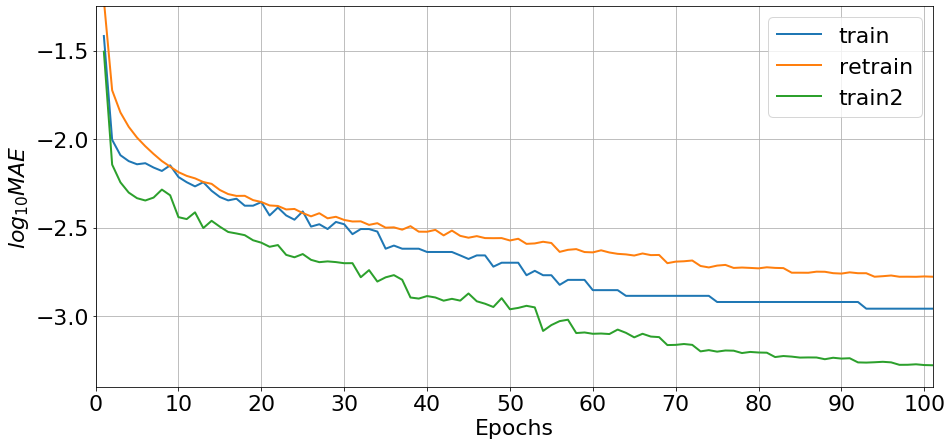

In [28]:
plt.figure(figsize=(15,7))

plt.rcParams['font.size'] = 22
plt.plot(np.arange(1, len(mae_3k) + 1, 1), np.log10(mae_3k), lw=2, label='train')
plt.plot(np.arange(1, len(mae_1) + 1, 1), np.log10(mae_1), lw=2, label='retrain')
plt.plot(np.arange(1, len(mae_2) + 1, 1), np.log10(mae_2), lw=2, label='train2')
plt.xlim([0, 101])
plt.xticks(np.arange(0, 101, 10))
plt.ylim([-3.4, -1.25])
plt.xlabel('Epochs')
plt.ylabel('$log_{10}MAE$')
plt.legend(loc='upper right')
plt.grid()

plt.show()